# Example: Mean-reversion Trader
In this example, we'll explore a mean reversion trading agent, a type of [technical analysis trading](https://www.schwab.com/learn/story/getting-started-with-technical-analysis). This agent will later serve as our `expert` that we observe. The expert technical trader will monitor market price trends, and then non-expert trading agents (us) observe the actions of the technical traders. We'll use `1-min` aggregate data of the [`QQQ` ETF year to date in 2024](https://oneminutedata.com/free-intraday-data) as our trading instrument.

## Learning objectives
* __Prerequisites__: Before setting up the simulation, we'll load and process the `1-min` aggregate share price data for `QQQ.` Then, we set some constant values that we'll use later.
* __Task 1__: In this task, we'll compute the simple moving average of the typical price (`tp`) of `QQQ,` and develop a decision boundary which we'll use in the subsequent tasks to formulate a trading policy.
* __Task 2__: In this task, we'll explore the performance of a trader using the mean reversion strategy developed in Task 1.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Constants and process the aggregate share price data
Before setting up the simulation, we load and process the 1-minute aggregate share price data for `QQQ.` Then, we set some constant values that we'll use throughout the rest of the notebook. 

### Load and process the `QQQ` data
The 1-minute aggregate `QQQ` data used in this project (which is YTD for the `2024` trading year) was downloaded from [oneminutedata.com](https://oneminutedata.com). The `QQQ` dataset, which is stored as a [comma-separated value (CSV) file](https://en.wikipedia.org/wiki/Comma-separated_values), is loaded using the [read method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) as a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl). We save the `QQQ` data in the `share_price_data_df::DataFrame` variable:

In [6]:
share_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "QQQ-OHLC-1-min-aggregate-2024.csv"), DataFrame)

Row,date,open,high,low,close,volume
,String31,Float64,Float64,Float64,Float64,Int64
1,2024-01-02 09:30:00,405.84,406.0,405.32,406.0,685991
2,2024-01-02 09:31:00,406.0,406.09,405.76,405.96,183013
3,2024-01-02 09:32:00,405.94,406.02,405.62,405.85,264177
4,2024-01-02 09:33:00,405.82,405.82,405.317,405.48,393224
5,2024-01-02 09:34:00,405.47,405.48,405.05,405.09,308977
6,2024-01-02 09:35:00,405.09,405.34,404.97,405.31,182471
7,2024-01-02 09:36:00,405.33,405.33,404.86,404.94,150399
8,2024-01-02 09:37:00,404.93,405.03,404.75,404.84,201293
9,2024-01-02 09:38:00,404.84,404.85,404.24,404.41,242375


Next, compute the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) using [the `typicalprice(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.typicalprice) for the `share_price_data_df::DataFrame.` We save the typical price (defined as (h+l+c)/3) in the `typical_price_array::Array{Float64,1}` array.

In [8]:
typical_price_array = share_price_data_df[!,:open]; # we can choose different prices here

Next, augment the `share_price_data_df::DataFrame` to include the `typical_price_array::Array{Float64,1}` array, where we store this data in the `:typicalprice::Symbol` column. 
* What is the `:` about in `:typicalprice`? We add the typical price `tp` data to the `share_price_data_df::DataFrame` in the `:typicalprice` column. The `:` prefix indicates we use a [Julia Symbol type](https://docs.julialang.org/en/v1/base/base/#Core.Symbol) for this data column. The columns of a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl) are [Julia Symbols](https://docs.julialang.org/en/v1/base/base/#Core.Symbol), which are sort of like Strings but with a few interesting differences. [Check out the docs here!](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols)

In [10]:
share_price_data_df[:,:typicalprice] = typical_price_array # now the dataframe has the typical price data (h+l+c)/3

23790-element Vector{Float64}:
 405.84
 406.0
 405.94
 405.82
 405.47
 405.09
 405.33
 404.93
 404.84
 404.43
 404.38
 404.2
 403.93
   ⋮
 444.45
 444.52
 444.49
 444.39
 444.6199
 444.59
 444.435
 444.43
 444.59
 444.59
 444.69
 444.575

Finally, let's specify some constants that we'll use later. See the comments following the value to describe what it is and its permissible values.

In [12]:
number_of_trading_periods = length(typical_price_array); # how many minutes of 2024 data do we have?
start_trading_index = 2; # what trading day index are going to 
length_of_autotrading_run = 20; # number of 6-hour blocks
start_index = 30+length_of_autotrading_run*360*(start_trading_index-1);  # index to start viewing the data. This value needs to >= 1
stop_index = start_index + length_of_autotrading_run*360; # index where we stop viewing the data. This value needs to be <= to number_of_trading_periods
view_range = range(start_index, stop = stop_index, step = 1) |> collect; # view_range is the range we use to look at (simulate) the data

## Task 1: Compute simple moving average trade signal trajectory
In this task, we'll compute the simple moving average of the typical price of `QQQ,` and develop a decision boundary, which we'll use in the subsequent tasks to formulate a trading policy for cells on the edge of our grid world. We'll use an [incremental simple moving average](https://en.wikipedia.org/wiki/Moving_average) where the average price is updated with new data as the algorithm marches through time. 
Let the typical price in period $\tau$ be given by $S_{\tau}$ (units: `USD/share`) and the moving average of the `tp` at time $\tau$ be given by $\hat{S}_{\tau}$ (units: `USD/share`). 
$$
\begin{equation}
\hat{S}_{\tau} = \hat{S}_{\tau - 1} + \alpha(\tau)\cdot\left(S_{\tau} - \hat{S}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function`.  The `learning function` controls how much new information is included in the update between $(\tau-1)\rightarrow\tau$. For example, if $\alpha(\tau) = 0$, no new information is added to the updated average estimate. 
* __What value for $\alpha(\tau)$__? A simple moving average computed over a time window of length $\mathcal{L}\geq{1}$ has a `learning function` given by $\alpha(\tau) = \mathcal{L}^{-1}$. Thus, as the window length increases in size, i.e., $\mathcal{L}\rightarrow\infty$, the simple moving average learning rate goes to zero $\alpha(\tau) \rightarrow{0}$. We'll select a $\alpha(\tau)$ value to capture some desired time scale.

Let's specify a constant value for the `learning function` such that $0<\alpha(\tau)<1$, and save it in the `α::Float64` variable (units: `1/min`). Notice the units; what does this look like?

In [14]:
α = (1/180); # students can update this! what happens if we recompute the mvap_array with diff values of α?

Next, using the incremental update expression above, let's populate the `mvap_array::Array{Float64,1}` array. First, we initialize some memory, and next, we initialize the average `mtypicalprice` series with the `typicalprice` value, in this case, the actual `typicalprice` value. Thus, at the first time step (array index `1`), the `mtypicalprice = typicalprice`. Then, we compute the moving average using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for).
* For each time step `2 ... number_of_trading_periods`, we use the incremental update expression to compute the average value and store it in the `mtypical_price_array::Array{Float64,1}` array.

In [16]:
mtypical_price_array = Array{Float64,1}(undef, number_of_trading_periods);
mtypical_price_array[1] = typical_price_array[1]; 

for i ∈ 2:number_of_trading_periods
    previous_mtp = mtypical_price_array[i-1];
    current_tp = typical_price_array[i];
    mtypical_price_array[i] = previous_mtp + α*(current_tp - previous_mtp);
end

#### Visualize the MTP
`Unihide` the code block below to see how we plotted the actual and moving volume weighted average for `1-min` aggregates of `QQQ.`
* The `typicalprice` for `QQQ` is shown in the blue-line, while the moving average of the typical price (mtp) is shown by the red-line. The mtp is a smoothed and lagged version of the `typicalprice` with the high-frequency information removed. Thus, it gives a slower picture of the `typicalprice` dynamics. The $\alpha(\tau)$ parameter controls the inclusion of fast or slow dynamics.
* __What is the signifinance of $\alpha(\tau)$__? The parameter $\alpha(\tau)$ represents a time constant measured in units of `1/min`. When $\alpha(\tau)$ is large, the moving volume-weighted average price (mtp) trajectory includes high-frequency data. Conversely, when $\alpha(\tau)$ is small, only slow dynamics or low-frequency information is retained in the mtp. This means that data with a frequency of $\alpha(\tau)$ or below is included in the mtp, while data with a frequency greater than $\alpha(\tau)$ is excluded.

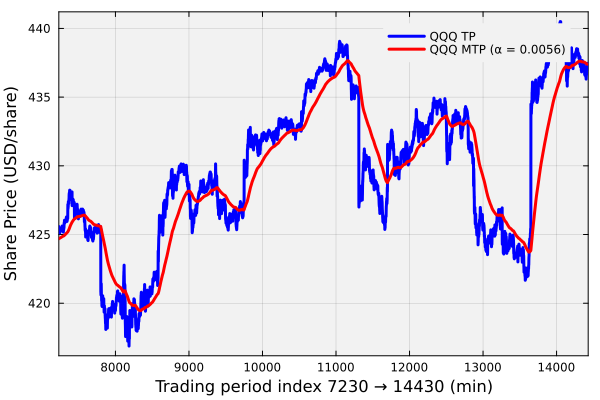

In [18]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, view_range, typical_price_array[view_range],c=:blue, xlims=(first(view_range), last(view_range)), lw=3, label="QQQ TP")
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw=3, label="QQQ MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index $(first(view_range)) → $(last(view_range)) (min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

### TODO: Develop a decision boundary
The moving average typical price (mtp) gives us a reference trajectory to use as a decision boundary, i.e., a `QQQ` price level that we'll use to make `{buy, hold, sell}` decisions. 
* `Hypothesis`: If `typicalprice` < `mtypicalprice,` we'll buy shares as we expect `QQQ` to be oversold, and the price will revert to the `mtypicalprice` value. On the other hand, if `typicalprice` > `mtypicalprice,`  we will sell shares. In this case, we expect that `QQQ` is overbought, and the price will drop to the `mtp` price.

However, let's refine this hypothesis further and add a buffer of size $\pm\,\beta\cdot\sigma$ around the `mtypicalprice` trajectory in which we hold, i.e., do not sell any shares. The multiplier $\beta$ is a user-adjustable hyperparameter, while $\sigma$ is the standard deviation of the `mtypicalprice,` that we calculate next. This is [a similar concept to Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands).

#### Calculate the decision boundary standard deviation
Like the incremental moving average for the share price shown above, suppose the average standard deviation at time step $\tau$ is given by $\hat{\sigma}_{\tau}$. We can incrementally update this value as new data becomes available. By analogy to the price expression, we propose an update rule for the standard deviation, which we'll use in our decision process, of the form:
$$
\begin{equation}
\hat{\sigma}_{\tau} = \hat{\sigma}_{\tau - 1} + \alpha(\tau)\cdot\left(\epsilon_{\tau} - \hat{\sigma}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function` from above, and $\epsilon_{\tau}$ is the 1-step standard deviation given by the expression:
$$
\begin{equation}
\epsilon_{\tau} = \sqrt{\left(S_{\tau} - \hat{S}_{\tau}\right)^2}
\end{equation}
$$
The $S_{\tau}$ value denotes the typical price at time $\tau$, while the $\hat{S}_{\tau}$ term denotes the moving average typical price (mtp) at time $\tau$. Thus, the $\epsilon_{\tau}$ term measures the residual between the `tp` and the `mtp` price. 
* To implement the moving average calculation, first, we allocate some space for the $\hat{\sigma}_{\tau}$ values in the `decision_boundary_array::Array{Float64,1}` array. We then initialize the first value of this series to zero, i.e., we have complete knowledge of the average price at index `1` because we know that `tp = mtp` at index `1,` thus $\hat{\sigma}_{1} = 0$. Then, we process each time step `2 ... number_of_trading_periods` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we implement the incremental update expression above and store the result in the `decision_boundary_array::Array{Float64,1}` array.

In [21]:
decision_boundary_array = Array{Float64,1}(undef, number_of_trading_periods);
decision_boundary_array[1] = 0.0;
for i ∈ 2:(number_of_trading_periods)
    previous_decision_boundary = decision_boundary_array[i-1];
    ϵ = (typical_price_array[i] - mtypical_price_array[i])^2 |> x -> sqrt(x);
    decision_boundary_array[i] = previous_decision_boundary + α*(ϵ - previous_decision_boundary);
end

#### Visualize the decision boundary
Let's plot the `decision_boundary_array,` i.e., the $\hat{\sigma}_{\tau}$ values, along with the tp and mtp trajectories, to see the decision boundaries. First, select a value for the multiplier hyperparameter $\beta$. 
* __What does $\beta$ do__? This user-adjustable parameter controls the width of the hold band. The $\beta$ parameter is akin to a [z-value in statistics](https://en.wikipedia.org/wiki/Standard_score); large values of $\beta$ will lead to a wide hold band, which means only extreme events will be clearly classified as buy or sell signals. On the other hand, small $\beta$ values will allow more buy and sell moves. For now, let's set `β = 1`, i.e., $\pm$ one standard deviation of moves will be hold moves, and approximately 30% of price moves will generate buy or sell signals. 

In [23]:
β = 1.0;

`Unhide` the code block below to reveal the code for plotting the tp, the mtp, and the decision boundary trajectory for the `β = 1` case.
* The tp is shown by the blue line, the moving volume-weighted average price (mtp) is shown in the red line, and the $\pm\,\beta\cdot\hat{\sigma}_{\tau}$ region around the mtp is shown in the gray shaded region. We can now use the hold region, i.e., the gray region, as the boundary for our auto-trading agent.
* Values of tp inside the gray region indicate our agent is in the hold state. On the other hand, if the tp falls below the gray region, the agent will be in the buy state. Finally, for tp values above the gray region, the agent will be in the sell state.
* We can imagine that each agent has a unique risk tolerance represented by a different value of $\beta$, and also a different value for the `learning function` $\alpha(\tau)$. Consequently, each agent might make different decisions based on their parameter values.

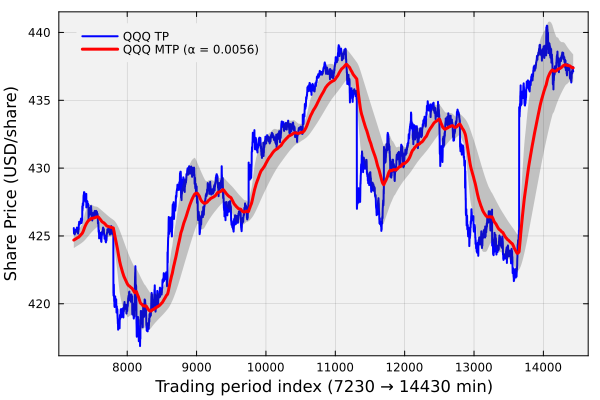

In [25]:
let    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, view_range, typical_price_array[view_range],c=:blue, lw=2, label = "QQQ TP")

    UB = mtypical_price_array[view_range] + β*decision_boundary_array[view_range];
    LB = mtypical_price_array[view_range] - β*decision_boundary_array[view_range];
    plot!(view_range, mtypical_price_array[view_range], fillrange = UB, label="", alpha=0.25, c=:gray20)
    plot!(view_range, mtypical_price_array[view_range], fillrange = LB, label="", alpha=0.25, c=:gray20)
    plot!(view_range, mtypical_price_array[view_range], c=:red, lw = 3, label="QQQ MTP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

## Task 2: How well does a mean-reversion trading strategy perform?
In this task, we'll explore the performance of a trader using the mean reversion strategy developed in Task 1. Let's construct the array that holds the actions of the agent. The `encoded_decision_action_array::Array{Int64,1}` holds the action the trading agent (as `0`, `1`, or `2`) will take at each time step. Our trading agent chooses an action from $\mathcal{A} \equiv \left\{\text{buy},\text{hold},\text{sell}\right\}$, where `0 = buy`, `1 = hold` and `2 = sell`. 

In [27]:
encoded_decision_action_array = let

    # initialize -
    number_of_trading_periods = length(view_range);
    UB = mtypical_price_array[view_range] + β*decision_boundary_array[view_range]; # upper bound: above this: sell
    LB = mtypical_price_array[view_range] - β*decision_boundary_array[view_range]; # lower bound: below this buy    
    encoded_state_array = Array{Int64,1}(undef, number_of_trading_periods);
    
    for i ∈ eachindex(view_range)

        j = view_range[i];
        
        typical_price = typical_price_array[j]; # observed open
        if (typical_price ≤ LB[i])
            encoded_state_array[i] = 0; # buy
        elseif (typical_price ≥ UB[i])
            encoded_state_array[i] = 2; # sell
        else
            encoded_state_array[i] = 1; # hold
        end        
    end

    # return -
    encoded_state_array;
end;

Now that we have the action states, we can simulate the trader's performance with some typical values. This algorithm below makes a few implementation assumptions that are worth discussion:
* __Random fill price__: We assume that when an agent buys or sells shares, they purchase (or sell) the shares at a random price value between the `low` and `high` value observed in the period. In this implementation, orders _always get filled_.
* __Purchase and sell volumes__: The agent buys `buy_side_order_volume::Float64` number of shares when purchasing shares, and sells $\theta$ fraction of thier position when selling the shares. The agent can not sell shares they don't own.
* __Budget__: The agent has an investment budget of `B USD` that they can spend. The agent cannot borrow money.

In [29]:
ledger_random_fill = let

    # initialize -
    number_of_trading_periods = length(view_range);
    n = 0.0; # we initially have this many shares
    B = 1000.0; # initial budget of the agent
    buy_side_order_volume = 0.1; # if we do buy, how big is the order?
    θ = 0.5; # if we do sell, how much do we sell?
    value = 0.0;
    
    ledger = DataFrame();

    cash_dictionary = Dict{Int64,Float64}();
    cash_dictionary[0] = 0.0; # we start out with some number
    shares_dictionary = Dict{Int64,Float64}();
    shares_dictionary[0] = n;
    
    # at what price do we get filled?
    average_placement_price = 
    for i ∈ eachindex(view_range)
        
        j = view_range[i];
        low = share_price_data_df[j,:low];
        high = share_price_data_df[j,:high];
        filled_price = rand(low:high); # we are somewhere between the low and high price for the period
        
        action = encoded_decision_action_array[i]; # what action do we do?
        if (action == 0) # buy

            # do we have enough money to make this trade? Need to check by budget
            cost_of_proposed_trade = buy_side_order_volume*filled_price;
            if (cost_of_proposed_trade ≤ B)

                # update 
                cash_dictionary[i] = cash_dictionary[i-1] - buy_side_order_volume*filled_price; # update the cash dictionary
                shares_dictionary[i] = shares_dictionary[i-1]+buy_side_order_volume; # update the shares dictionary
                B += -1*cost_of_proposed_trade; # update the budget
    
            else

                # We don't have enough money to implement this trade, so we hold
                shares_dictionary[i] = shares_dictionary[i-1]; # no change
                cash_dictionary[i] = cash_dictionary[i-1]; # no change
                
            end
            
        elseif (action == 2) # sell
            if (shares_dictionary[i-1] ≥ 0)

                n_sell = θ*shares_dictionary[i-1]; # sell θ fraction of my current position
                cost_of_proposed_trade = n_sell*filled_price;
                
                cash_dictionary[i] = cash_dictionary[i-1] + cost_of_proposed_trade # update the cash dictionary
                shares_dictionary[i] = (1-θ)*shares_dictionary[i-1]; # how many shares do we have left?  
                B += 1*cost_of_proposed_trade; # update the budget
            end
        else
            # println("Hold action: current $(value) USD")
            shares_dictionary[i] = shares_dictionary[i-1]; # no change
            cash_dictionary[i] = cash_dictionary[i-1]; # no change
        end

        # compute some stuff -
        Δn = shares_dictionary[i] - shares_dictionary[i-1];
        Δcash = cash_dictionary[i] - cash_dictionary[i-1];
        
        # capture data -
        row_df = (
            timeperiod = i,
            action = action,
            fillprice = filled_price,
            nₒ = shares_dictionary[i-1],
            nᵢ = shares_dictionary[i],
            Δn = Δn,
            B = B,
            cashₒ = cash_dictionary[i-1],
            cash₁ = cash_dictionary[i],
            Δcash = Δcash, 
            LV = (shares_dictionary[i])*filled_price,
            total = cash_dictionary[i] + (shares_dictionary[i])*filled_price
        );
        push!(ledger, row_df);
    end

   ledger;
end;

In [136]:
filter(:action => a-> a == 2, ledger_random_fill[900:2000,:])

Row,timeperiod,action,fillprice,nₒ,nᵢ,Δn,B,cashₒ,cash₁,Δcash,LV,total
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1123,2,420.655,2.35,1.175,-1.175,500.571,-993.699,-499.429,494.27,494.27,-5.1593
2,1163,2,420.68,1.175,0.5875,-0.5875,747.721,-499.429,-252.279,247.15,247.15,-5.12992
3,1164,2,420.84,0.5875,0.29375,-0.29375,871.342,-252.279,-128.658,123.622,123.622,-5.03592
4,1165,2,420.983,0.29375,0.146875,-0.146875,933.174,-128.658,-66.8258,61.8319,61.8319,-4.99389
5,1166,2,421.01,0.146875,0.0734375,-0.0734375,964.092,-66.8258,-35.9079,30.9179,30.9179,-4.98994
6,1167,2,421.07,0.0734375,0.0367188,-0.0367188,979.553,-35.9079,-20.4467,15.4612,15.4612,-4.98553
7,1168,2,421.12,0.0367188,0.0183594,-0.0183594,987.285,-20.4467,-12.7152,7.7315,7.7315,-4.9837
8,1169,2,420.69,0.0183594,0.00917969,-0.00917969,991.147,-12.7152,-8.85339,3.8618,3.8618,-4.99159
9,1204,2,420.795,0.00917969,0.00458984,-0.00458984,993.078,-8.85339,-6.92201,1.93138,1.93138,-4.99063


### Visualize
Let's visualize the total value of the agent's portfolio, and the budget available as a function to time.

#### Budget

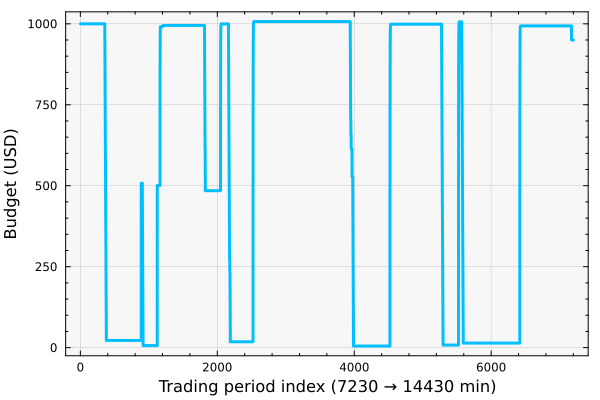

In [126]:
let
    plot(ledger_random_fill[:,:B], c=:deepskyblue1, lw=3, label="", linetype=:steppost, bg="gray97", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18,  xminorticks=5, yminorticks=5)
    ylabel!("Budget (USD)", fontsize=18);
end

#### Total

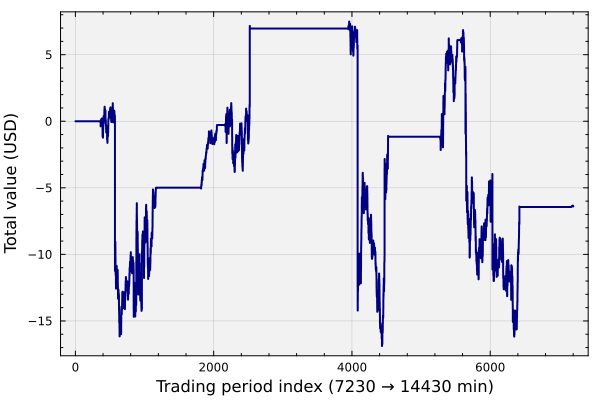

In [122]:
let
    plot(ledger_random_fill[:,:total], c=:navy, lw=2, label="", linetype=:steppost, bg="gray95", background_color_outside="white", 
        framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18,  xminorticks=5, yminorticks=5)
    ylabel!("Total value (USD)", fontsize=18);
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.